# Exploring Gini and Lorenz

See Bernasco and Steenbeck - *More Places than Crimes: Implications for Evaluating
the Law of Crime Concentration at Place*

Specifically identifying a baseline curve from which a concentration measure can be computed 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import CATEGORIES, Month, calc_gini, load_crime_data, lorenz_curve, monthgen, random_crime_data_by_point

Set up parameters: 
- crime type
- force and spatial units
- time window

In [3]:
FORCE = "West Yorkshire"
CATEGORY = CATEGORIES[1]  # ASB
AREA: SpatialUnit = "GRID"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "GC"},
        "GRID": {"size": 1000.0},
        "HEX": {"size": 124.0},
        "H3": {"resolution": 8},
    },
)
LATEST_DATE = Month(2025, 5)
MONTHS = 36

## Part 1: inspect some real data

Get the data, place in the spatial units and aggregate to crime counts per spatial unit per month

In [4]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = load_crime_data(
    FORCE, monthgen(LATEST_DATE, end=LATEST_DATE - MONTHS), filters={"Crime type": CATEGORY}
)
# remove any points outside boundary
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
crime_data, features = map_to_spatial_unit(raw_crime_data, force_boundary, AREA, **AREA_PARAMETERS[AREA])

count_data = (
    crime_data.groupby(["Month", "spatial_unit"])["Crime type"]
    .count()
    .unstack(level="Month", fill_value=0)
    .reindex(features.index, fill_value=0)
)
assert len(count_data) == len(features)

count_data

Month,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,...,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Calculate and display Lorenz curves for each month


<Axes: title={'center': 'Lorenz Curves for Crime Counts by Month'}>

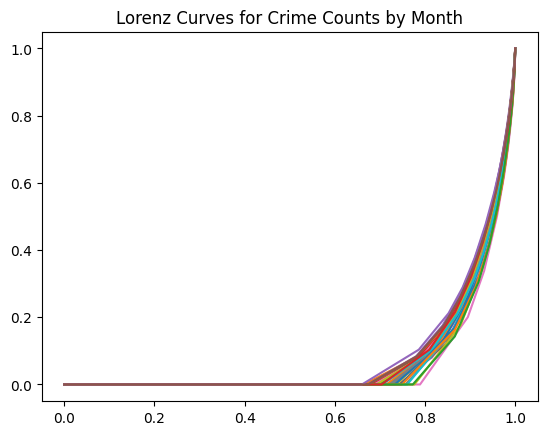

In [5]:
data = {m: lorenz_curve(c) for m, c in count_data.items()}
lorenz_curves = pd.DataFrame(data)
lorenz_curves.plot(legend=False, title="Lorenz Curves for Crime Counts by Month")

## Part 2: Simulate

Using the same crime count and number of spatial units from the real data, we simulate random *i.i.d.* crimes to 
demonstrate that:
- the assumption in the standard Gini formula - that the Lorenz curve is a straight line from (0, 0) to (1, 1) is flawed.
- to produce such a curve would require a space-filling (and thus non-independent) stochastic process.
- any independent process will naturally have clusters and gaps, and is incorrect to infer any causality from this 
observation

The biggest deviation from the original Gini assumption is most obvious when there are zeros in the data, e.g. when the 
number of spatial units is greater than the crime count.

NOTE: this assumes the same Poisson intensity $\lambda$ in each spatial unit, which may not be the case. I think the 
Poisson-Gamma work tries to address this.


In [6]:
n_spatial_units = len(features)
n_crimes_per_month = round(count_data.sum().mean())

lambda_ = n_crimes_per_month / n_spatial_units
f"{n_crimes_per_month=} {n_spatial_units=} {lambda_=}"  # the mean count of incidents

'n_crimes_per_month=2284 n_spatial_units=2181 lambda_=1.0472260430994957'

Construct a Poisson distribution, simulate crimes and aggregate to spatial units

The Poisson PDF is

$$
f(k; \lambda) = \frac{\lambda^ke^{-\lambda}}{k!}
$$

where $k$ is the observed count and $\lambda$ the mean.

In [7]:
rng = np.random.default_rng()


def get_sample(n_spatial_units, n_crimes_per_month) -> pd.Series:
    raw = rng.choice(range(n_spatial_units), n_crimes_per_month)
    indices, counts = np.unique(raw, return_counts=True)

    sample = pd.Series(index=indices, data=counts).reindex(range(n_spatial_units), fill_value=0)
    return sample


sample = get_sample(n_spatial_units, n_crimes_per_month)
counts = (sample.groupby(sample).count() / n_spatial_units).rename("sim").to_frame()

Check the simulation by comparing to the PDF

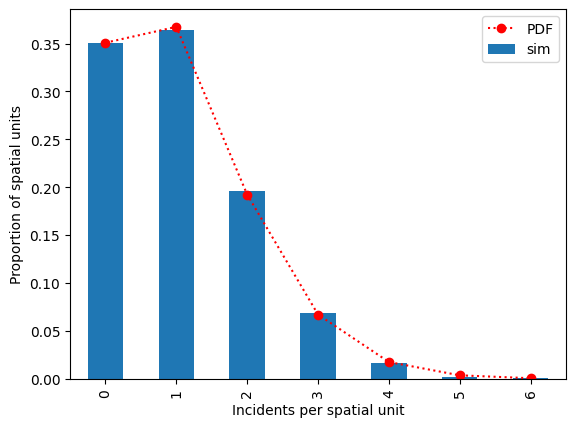

In [8]:
dist = poisson(lambda_)

counts["pdf"] = counts.index.map(dist.pmf)  # * n_spatial_units
ax = counts.sim.plot.bar()
ax.plot(counts.pdf, ":", c="r", marker="o", label="PDF")
ax.set_xlabel("Incidents per spatial unit")
ax.set_ylabel("Proportion of spatial units")
ax.legend();

## Lorenz curve

The theoretical Lorenz curve for independent samples is the cumulative sum of inverse CDF $Q(x; \lambda) = F^{-1}(x; \lambda)$ of the Poisson distribution

$$
L_0(x) = \int_0^x{Q(y; \lambda) dy} \bigg/ \int_0^1{Q(y; \lambda) dy}
$$

We compare the simulated Lorentz curve to the analytical formula, showing how it deviates significantly from the original assumption

This should be used as the baseline for the Gini calculation - basically the red shaded area

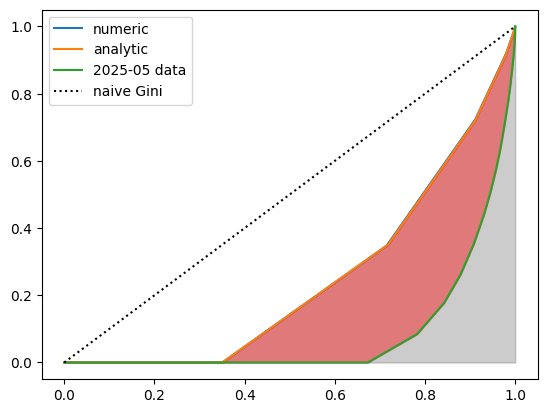

In [9]:
lorenz = lorenz_curve(sample).rename("numeric").to_frame()
# lorenz["diff"] = lorenz.lorenz.diff() * n_spatial_units
icdf = dist.ppf(lorenz.index)
icdf[0] = 0
lorenz["analytic"] = icdf.cumsum() / n_crimes_per_month
# fix...
lorenz.loc[1.0, "analytic"] = 1.0
ax = lorenz.plot()
lorenz_curves["2025-05"].plot(ax=ax, label="2025-05 data")
ax.plot([0, 1], [0, 1], ":", c="k", label="naive Gini")

ax.fill_between(lorenz_curves.index, 0, lorenz["analytic"], color="grey", alpha=0.4)
ax.fill_between(lorenz_curves.index, lorenz_curves["2025-05"], lorenz["analytic"], color="r", alpha=0.4)
ax.legend();

## Part 3: Adjusted Gini calculation and comparison

The standard Gini coefficient (for the green curve) is given by the ratio of area bounded by the black dotted line with 
the grey shaded area, which can be written as

$$
Gini = 1 - 2A_{grey}
$$

We define our adjusted Gini coefficient as the ratio of the red shaded area to the combined red and grey areas:

$$
Gini^\prime = \frac{A_{red}}{A_{red} + A_{grey}}
$$

The red and grey shaded areas is given by

$$
A_{red} + A_{grey} = \int_0^1{L_0(x)dx}
$$

which can be computed more conveniently directly from the Poisson PDF $f(k; \lambda)$ and CDF $F(k; \lambda)$:

$$
A_{red} + A_{grey} = \sum_{k=1}^\infty {f(k; \lambda)\frac{(F(k-1; \lambda) + F(k-2; \lambda))}{2}}
$$

here CDF values for negative $k$ are zero


In [ ]:
def poisson_lorenz_sum(dist):
    # work out how many terms we need to sum
    length = 5
    while dist.cdf(length) < 1 - 1e-16:  # this seems to get double precision
        length += 1

    print(length)

    # sum( p(k) * (P(k-1) + P(k-2)) / 2)
    pdf = dist.pmf(range(1, length))
    cdf = (dist.cdf(range(-1, length - 2)) + dist.cdf(range(length - 1))) / 2



    return pdf @ cdf

def poisson_lorenz_sum2(n_crimes: int, n_features: int):
    "This works better than above but still has wobbles"
    x = np.linspace(0, 1, n_features)
    x[0] = 1e-9
    icdf = poisson(n_crimes / n_features).ppf(x)
    lorenz0 = icdf.cumsum() / n_crimes
    lorenz0[-1] = 1.0

    return lorenz0.mean()

A0old = poisson_lorenz_sum(dist)
A0 = poisson_lorenz_sum2(n_crimes_per_month, n_spatial_units)

# check numerically
A0check = lorenz.analytic.sum() / n_spatial_units  # len(lorenz)
A0, A0check, A0old

17


(np.float64(0.2433916221209924),
 np.float64(0.2433916221209924),
 np.float64(0.24306183843220464))

In [89]:
def f(lam):
    dist = poisson(lam)
    length = 5
    while dist.cdf(length) < 1 - 1e-10:  # this seems to get double precision
        length += 1

    print(length)

    x = dist.cdf(range(0, length))
    y = dist.pmf(range(0, length)) * range(length)

    print(x, y)

    df = pd.DataFrame(data={"x": x, "y": y})
    df.y = df.y.cumsum()
    # df["y"] = df.x.shift().fillna(0)
    return df

df = f(n_crimes_per_month / n_spatial_units)
df["g"] = df.y.diff() / df.x.diff()

#np.log(df["g"].mean())
df

13
[0.35090981 0.7183917  0.91081    0.97797849 0.99556364 0.99924676
 0.9998896  0.99998578 0.99999837 0.99999983 0.99999998 1.
 1.        ] [0.00000000e+00 3.67481891e-01 3.84836606e-01 2.01505458e-01
 7.03405879e-02 1.84156239e-02 3.85706419e-03 6.73203011e-04
 1.00713675e-04 1.31837479e-05 1.53404046e-06 1.60648712e-07
 1.52941378e-08]


,x,y,g
0,0.350910,0.000000,NaN
1,0.718392,0.367482,1.000000
2,0.910810,0.752318,2.000000
3,0.977978,0.953824,3.000000
4,0.995564,1.024165,4.000000
5,0.999247,1.042580,5.000000
6,0.999890,1.046437,6.000000
7,0.999986,1.047110,7.000000
8,0.999998,1.047211,8.000000
9,1.000000,1.047224,9.000000


Naive Gini       0.848654
Adjusted Gini    0.689389
dtype: float64

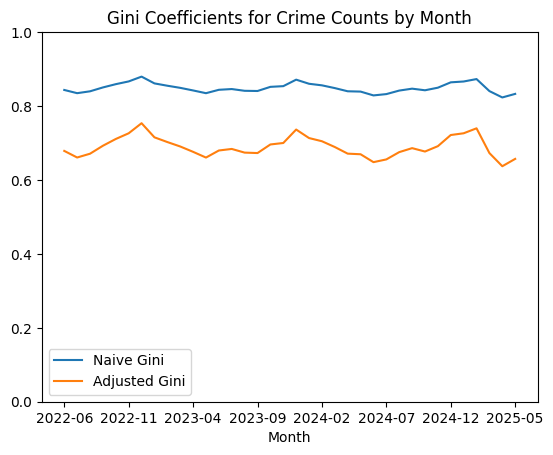

In [ ]:
def adjusted_gini(lorenz: pd.Series, A0: float) -> float:
    """
    Calculate the adjusted Gini coefficient from a Lorenz curve and the A0 value.
    """
    # A0 is red + grey in graph above
    A = lorenz.sum() / len(lorenz)
    return (A0 - A) / A0


gini = pd.DataFrame(index=count_data.columns)

gini["Naive Gini"] = gini.index.map(lambda m: calc_gini(count_data[m])[0])
gini["Adjusted Gini"] = gini.index.map(lambda m: adjusted_gini(lorenz_curves[m], A0))
ax = gini.plot(ylim=(0, 1), title="Gini Coefficients for Crime Counts by Month")
gini.mean()

Compare Gini and adjusted Gini for our data

## Do we have any scale invariance?

Generate random data and see how Gini and adjusted Gini vary by spatial scale

### Adjusted Gini should be ~0 for purely random data

In [17]:
N = len(crime_data) // 36
AREA: SpatialUnit = "GRID"

In [30]:
def compute_spatial_variation(
    raw_random_crimes: gpd.GeoDataFrame, boundary: gpd.GeoDataFrame
) -> tuple[pd.DataFrame, pd.DataFrame]:
    # evenly spaced log(area) scale
    size = np.exp(np.linspace(np.log(100**2), np.log(5000**2), 12) / 2)

    lorenz_curves = []
    gini = pd.DataFrame(index=size, columns=["Naive Gini", "Adjusted Gini", "L", "A0"])

    for size in gini.index:
        random_crimes, features = map_to_spatial_unit(raw_random_crimes, boundary, AREA, size=size)

        count_data = random_crimes.groupby("spatial_unit")["Crime type"].count().reindex(features.index, fill_value=0)
        assert len(count_data) == len(features)

        lambda_ = len(raw_random_crimes) / len(features)
        A0 = poisson_lorenz_sum2(len(raw_random_crimes), len(features))

        gini.loc[size, "A0"] = A0

        gc, lc = calc_gini(count_data)
        gini.loc[size, "Naive Gini"] = gc

        gini.loc[size, "Adjusted Gini"] = adjusted_gini(lc, A0)
        gini.loc[size, "L"] = lc.mean()

        lorenz_curves.append(lc.rename(f"{size:.0f}m"))

    return pd.concat(lorenz_curves, axis=1), gini


def plot_lorenz_gini(lorenz_curves: pd.DataFrame, gini: pd.DataFrame, desc: str) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Lorenz and Gini by grid size, {desc}")
    lorenz_curves.plot(
        ax=axs[0], title="Lorenz curves", xlabel="Cumulative spatial units", ylabel="Cumultative crime", legend=True
    )
    gini.plot(
        ax=axs[1],
        title="Gini coefficient",
        logx=True,
        ylim=axs[0].get_ylim(),
        xlabel="Grid size (m)",
        ylabel="Concentraion",
        marker=".",
    )

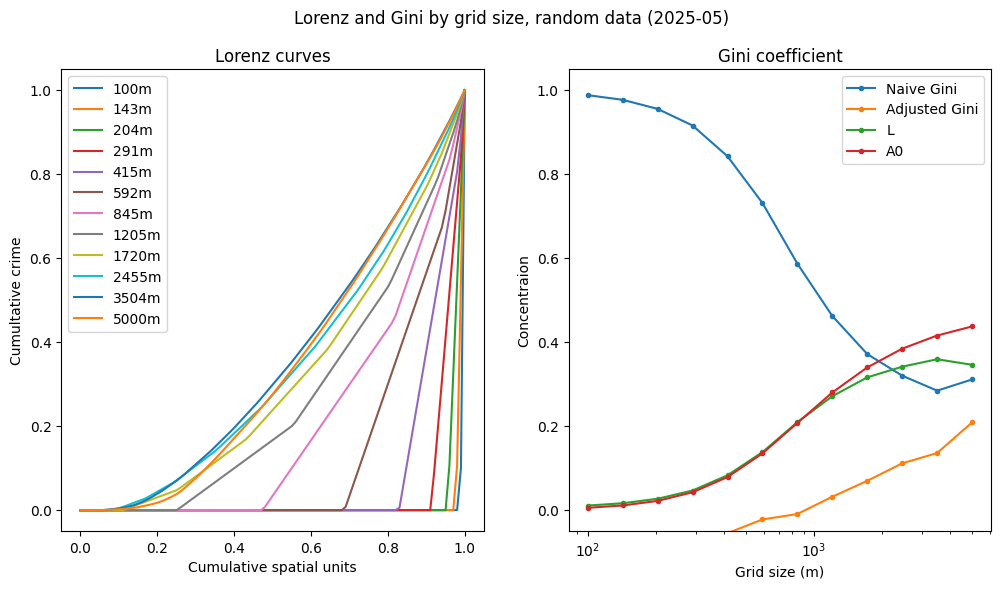

In [31]:
raw_random_crimes = random_crime_data_by_point(N, force_boundary, [LATEST_DATE], seed=19937)
random_lorenz_curves, random_gini = compute_spatial_variation(raw_random_crimes, force_boundary)
plot_lorenz_gini(random_lorenz_curves, random_gini, f"random data ({LATEST_DATE})")

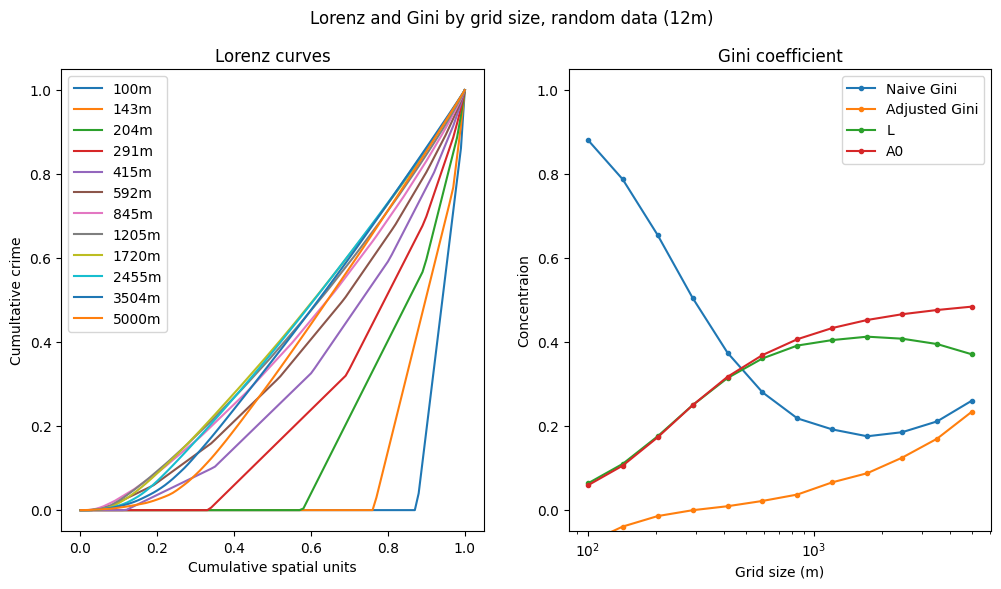

In [32]:
raw_random_crimes = random_crime_data_by_point(N * 12, force_boundary, [LATEST_DATE], seed=19937)
random_lorenz_curves, random_gini = compute_spatial_variation(raw_random_crimes, force_boundary)
plot_lorenz_gini(random_lorenz_curves, random_gini, "random data (12m)")

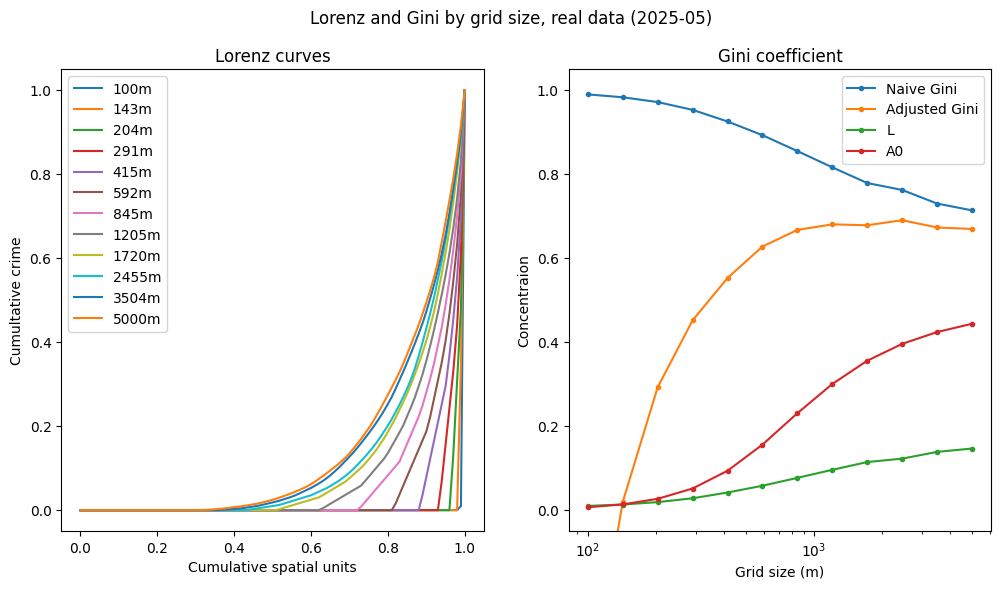

In [33]:
m = LATEST_DATE
real_lorenz_curves, real_gini = compute_spatial_variation(
    raw_crime_data[raw_crime_data.Month == str(m)], force_boundary
)
plot_lorenz_gini(real_lorenz_curves, real_gini, f"real data ({m})")

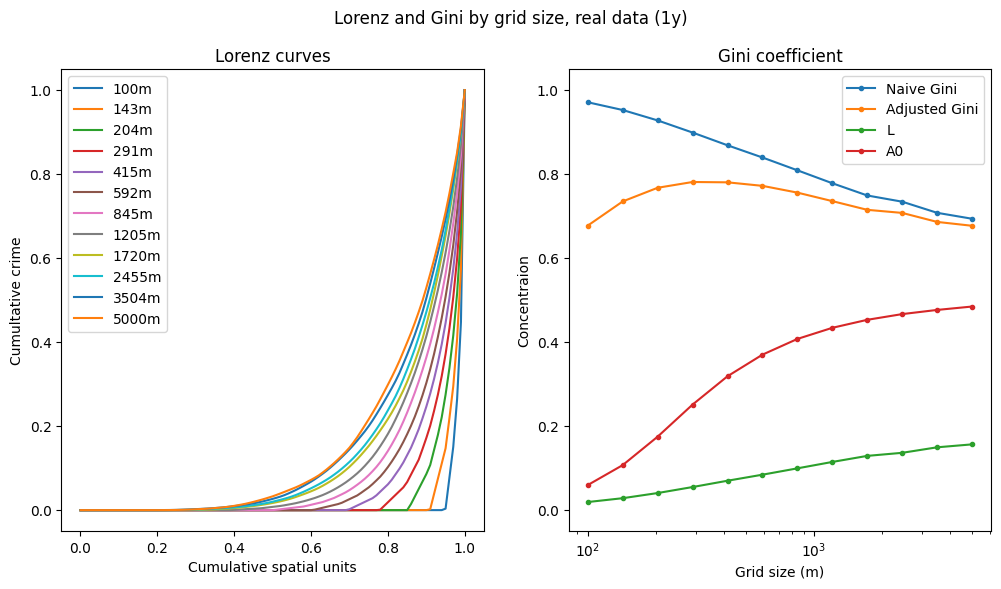

In [34]:
raw_crime_data_1y = raw_crime_data[raw_crime_data.Month > "2024-05"]
raw_crime_data_1y.loc[:, "Month"] = "(1y)"
real_lorenz_curves_1y, real_gini_1y = compute_spatial_variation(raw_crime_data_1y, force_boundary)
plot_lorenz_gini(real_lorenz_curves_1y, real_gini_1y, f"real data (1y)")